In [ ]:
import nbpresent
nbpresent.__version__

# _Fit Your Learning Curves for Fun and Profit_
## David Nicholson
### Graduate student, Emory Neuroscience
# Jupyter Day Atlanta 

## learning curves
* plot of error against size of training data set
![learning curves](./cortes_etal_1994_fig2.png)
<center>**Fig.2 from Cortes et al. 1994**</center>

## why bother?
* Consider these hypothetical learning curves:
![more learning curves](./cortes_etal_1994_fig1.png)

## Can we avoid a training set size of 50k samples?
* Yes! (Cortes et al., 1994)
* We'll train up a bunch of models with data sets of intermediate size that are quicker to train
* Then we'll estimate the error for each size of training set
* Lastly we'll plot the error points and fit a curve

## The curve we'll fit: a power function
* has the form: $y = a + bx^\alpha$
 + with the parameters:
     * $a$, the asymptote
     * $b$, the scaling factor
     * $\alpha$, the power or exponent
     

## Cortes et al.'s approach

* Consider these learning curves again

![learning curves](./cortes_etal_1994_fig2.png)
<center>**Fig.2 from Cortes et al. 1994**</center>

* We're going to assume both the training error and test error obey power functions 
* Further assume both go in the limit to the same asymptote $a$
* These assumptions give us two equations:
 1. $\epsilon_{test} = a + \frac{b}{l^\alpha}$
 2. $\epsilon_{train} = a - \frac{c}{l^\beta}$

## Cortes et al.'s approach

* Let's take the sum and difference of those two equations
<br>&nbsp; &nbsp;3. The sum: $\epsilon_{test} + \epsilon_{train} = 2a + \frac{b}{l^\alpha} - \frac{c}{l^\beta}$
<br>&nbsp; &nbsp;4. The difference: $\epsilon_{test} - \epsilon_{train} = \frac{b}{l^\alpha} + \frac{c}{l^\beta}$

* Assume further that $\alpha$ = $\beta$ and that $b$ = $c$
* Equations 3 and 4 now reduce to:
<br>&nbsp; &nbsp;5. $\epsilon_{test} + \epsilon_{train} = 2a$
<br>&nbsp; &nbsp;6. $\epsilon_{test} - \epsilon_{train} = \frac{2b}{l^\alpha}$
<!--- br and &nbsp above are to prevent automated list numbering from resetting count --->

## Cortes et al.'s approach

What's so special about the equations in this form?
<br>&nbsp; &nbsp;5. $\epsilon_{test} + \epsilon_{train} = 2a$
<br>&nbsp; &nbsp;6. $\epsilon_{test} - \epsilon_{train} = \frac{2b}{l^\alpha}$

They suggest we can apply a log transform to the data.

Both should yield points we can fit with straight lines to get estimates of the parameters we want for our curve.
![log_transform](./cortes_etal_1994_fig3.png)
<center>**Fig.3 from Cortes et al. 1994**</center>

## Cortes et al.'s approach
![cortes_algorithm](./cortes_etal_1994_algobox.png)


## Ok, cool. How well does the Cortes et al. approach work?

In [1]:
#setup
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve

from learn_curves import predict_learning_curve

## Let's generate some learning curves using scikit-learn

In [3]:
#borrows heavily from http://scikit-learn.org/stable/modules/learning_curve.html
train_sizes=np.linspace(.1, 1.0, 5)
digits = load_digits()
X, y = digits.data, digits.target

cv = cross_validation.ShuffleSplit(digits.data.shape[0], n_iter=20,
                                   test_size=0.2, random_state=0)
estimator_NB = GaussianNB()
train_sizes_NB, train_scores_NB, test_scores_NB = learning_curve(
    estimator_NB, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)

train_error_NB = 1 - train_scores_NB
test_error_NB = 1 - test_scores_NB
train_error_mean_NB = np.mean(train_error_NB, axis=1)
test_error_mean_NB = np.mean(test_error_NB, axis=1)

estimator_SVC = SVC(gamma=0.001)
train_sizes_SVC, train_scores_SVC, test_scores_SVC = learning_curve(
    estimator_SVC, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)

train_error_SVC = 1 - train_scores_SVC
test_error_SVC = 1 - test_scores_SVC
train_error_mean_SVC = np.mean(train_error_SVC, axis=1)
test_error_mean_SVC = np.mean(test_error_SVC, axis=1)

## How's the fit look for Gaussian Naive Bayes?

In [4]:
a,b,alpha = predict_learning_curve(train_sizes_NB,test_error_NB,train_error_NB)

powerfunc = lambda x,asymptote,scaling,exponent: asymptote + scaling * x**exponent
manypoints = np.arange(50,1650,50)
test_err_fit = powerfunc(manypoints,a,b,alpha)
train_err_fit = powerfunc(manypoints,a,b,-alpha)

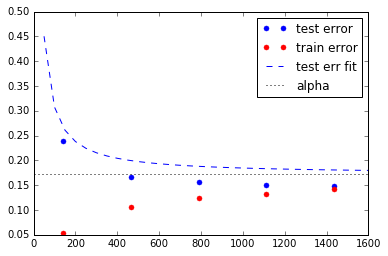

In [5]:
plt.plot(train_sizes_NB,test_error_mean_NB,'b.',markersize=10,label='test error')
plt.plot(train_sizes_NB,train_error_mean_NB,'r.',markersize=10,label='train error')
plt.plot(manypoints,test_err_fit,'b--',label='test err fit')
#plt.plot(manypoints,train_err_fit,'r--',label='train err fit')
plt.axhline(a,color='k',linestyle=':',label='alpha')
plt.legend()

** Clearly the asymptote and fit for the test error are both off using the Cortes et al. approach **

## Possible issues here
+ Assumption that $b$ and $c$ are equal, i.e., that exponent is same for both curves

## What if we try fitting two simultaneous equations?

/home/ildefonso/Documents/repositories/jupyter_day/learn_curves.py:17: RuntimeWarning: overflow encountered in power
  diff1 = (y1 - (asymptote + b  * alpha ** x))**2 / y1err
/home/ildefonso/Documents/repositories/jupyter_day/learn_curves.py:17: RuntimeWarning: overflow encountered in square
  diff1 = (y1 - (asymptote + b  * alpha ** x))**2 / y1err


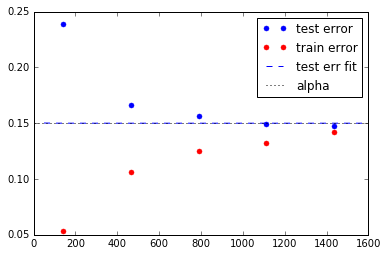

In [18]:
best = predict_learning_curve(train_sizes_NB,test_error_NB,train_error_NB,pinit=[0.66,-2.12,0.013,0.325,0.15],funcs=2)
b = best[0]
alpha = best[1]
c = best[2]
beta = best[3]
a = best[4]
powerfunc = lambda asymptote,scaling,exponent,x: asymptote + scaling * x**exponent
manypoints = np.arange(50,1650,50)
test_err_fit = powerfunc(a,b,alpha,manypoints)
train_err_fit = powerfunc(a,c,beta,manypoints)

plt.plot(train_sizes_NB,test_error_mean_NB,'b.',markersize=10,label='test error')
plt.plot(train_sizes_NB,train_error_mean_NB,'r.',markersize=10,label='train error')
plt.plot(manypoints,test_err_fit,'b--',label='test err fit')
#plt.plot(manypoints,train_err_fit,'r--',label='train err fit')
plt.axhline(a,color='k',linestyle=':',label='alpha')
plt.legend()

In [11]:
from scipy import optimize

In [12]:
fitfunc = lambda p, x: p[0] + p[1] * x   
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

logx = np.log10(train_sizes_NB)
y1 = np.mean(test_error_NB,axis=1)
y1err = np.std(test_error_NB,axis=1)
logy1 = np.log10(y1)
logy1err = y1err / y1
pinit = [1,-1.0]
out1 = optimize.leastsq(errfunc, pinit,
                   args=(logx, logy1, logy1err), full_output=1)
b = 10.0**out1[0][0]
alpha = out1[0][1]

pinit = [1,1.0]
y2 = np.mean(train_error_NB,axis=1)
y2err = np.std(train_error_NB,axis=1)
logy2 = np.log10(y2)
logy2err = y2err / y2
out2 = optimize.leastsq(errfunc, pinit,
                   args=(logx, logy2, logy2err), full_output=1)
c = 10.0**out2[0][0]
beta = out2[0][1]

powerfunc = lambda x,scaling,exponent: scaling * x ** exponent
manypoints = np.arange(50,1650,50)
test_err_fit = powerfunc(manypoints,b,alpha)
train_err_fit = powerfunc(manypoints,c,beta)

In [13]:
test_err_fit

array([ 0.28873381,  0.24919447,  0.22862549,  0.21506966,  0.20511097,
        0.19731741,  0.19095953,  0.18561792,  0.18103045,  0.17702297,
        0.17347425,  0.17029667,  0.167425  ,  0.16480945,  0.16241116,
        0.16019932,  0.15814906,  0.15624006,  0.15445551,  0.15278137,
        0.15120576,  0.1497186 ,  0.14831123,  0.14697616,  0.1457069 ,
        0.14449775,  0.14334371,  0.14224036,  0.14118379,  0.1401705 ,
        0.13919736,  0.13826155])

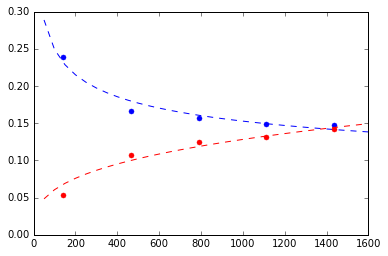

In [14]:
plt.plot(train_sizes_NB,test_error_mean_NB,'b.',markersize=10,label='test err')
plt.plot(manypoints,test_err_fit,'b--')
plt.plot(train_sizes_NB,train_error_mean_NB,'r.',markersize=10,label='train err')
plt.plot(manypoints,train_err_fit,'r--')

In [22]:
print("b",b)
print("alpha",alpha)
print("c",c)
print("beta",beta)
print("a",a)

b 0.66
alpha -2.12
c 0.013
beta 0.325
a 0.15
